In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn import preprocessing, linear_model, model_selection

%matplotlib inline

Класс моделей ARIMA недостаточно богат для наших данных: с их помощью, например, никак нельзя учесть взаимосвязи между рядами. Это можно сделать с помощью векторной авторегрессии VARIMA, но её питоновская реализация не позволяет использовать регрессионные признаки. Кроме того, авторегрессионный подход не позволяет учитывать, например, взаимодействия между сезонными компонентами. Вы могли заметить, что форма суточных сезонных профилей в будни и выходные немного разная; явно моделировать этот эффект с помощью ARIMA не получится.

Нам нужна более сложная модель. Давайте займёмся сведением задачи массового прогнозирования рядов к регрессионной постановке! Вам понадобится много признаков. Некоторые из них у вас уже есть — это:
<ol>
<li>идентификатор географической зоны
<li>дата и время
<li>количество поездок в периоды, предшествующие прогнозируемому
<li>синусы, косинусы и тренды, которые вы использовали внутри регрессионной компоненты ARIMA
<li>Кроме того, не спешите выбрасывать построенный вами на прошлой неделе прогнозы — из них может получиться хороший признак для регрессии!
</ol>



Вы можете попробовать разные регрессионный модели, но хорошие результаты, скорее всего, дадут такие, которые будут позволять признакам взаимодействовать друг с другом.

Поскольку прогноз нужен на 6 часов вперёд, проще всего будет построить 6 независимых регрессионных моделей — одна для прогнозирования y^T+1|T, другая для y^T+2|T и т.д.

<ol>Чтобы сдать задание, выполните следующую последовательность действий.
<li>Для каждой из шести задач прогнозирования y^T+i|T,i=1,…,6 сформируйте выборки. Откликом будет yT+i при всевозможных значениях T, а признаки можно использовать следующие:
<ul>
<li>идентификатор географической зоны — категориальный
<li>год, месяц, день месяца, день недели, час — эти признаки можно пробовать брать и категориальными, и непрерывными, можно даже и так, и так (done)
<li>синусы, косинусы и тренды, которые вы использовали внутри регрессионной компоненты ARIMA (done)
<li>сами значения прогнозов ARIMA y^T+i|TARIMA
<li>количество поездок из рассматриваемого района в моменты времени yT,yT−1,…,yT−K (параметр K можно подбирать; попробуйте начать, например, с 6)
<li>количество поездок из рассматриваемого района в моменты времени yT−24,yT−48,…,yT−24∗Kd (параметр Kd можно подбирать; попробуйте начать, например, с 2)
<li>суммарное количество поездок из рассматриваемого района за предшествующие полдня, сутки, неделю, месяц
</ul>
Будьте внимательны при создании признаков — все факторы должны быть рассчитаны без использования информации из будущего: при прогнозировании y^T+i|T,i=1,…,6 вы можете учитывать только значения y до момента времени T включительно.


<li>Выбранными моделями постройте для каждой географической зоны и каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 прогнозы на 6 часов вперёд; посчитайте в ноутбуке ошибку прогноза по следующему функционалу:
Qmay=1R∗739∗6∑r=1R∑T=2016.04.3023:002016.05.3117:00∑i=16y^T|T+ir−yT+ir.
Убедитесь, что ошибка полученных прогнозов, рассчитанная согласно функционалу Q, определённому на прошлой неделе, уменьшилась по сравнению с той, которую вы получили методом индивидуального применения моделей ARIMA. Если этого не произошло, попробуйте улучшить ваши модели.

<li>Итоговыми моделями постройте прогнозы для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 и запишите все результаты в один файл в формате geoID, histEndDay, histEndHour, step, y. Здесь geoID — идентификатор зоны, histEndDay — день конца истории в формате id,y, где столбец id состоит из склеенных через подчёркивание идентификатора географической зоны, даты конца истории, часа конца истории и номера отсчёта, на который делается предсказание (1-6); столбец y — ваш прогноз.

<li>Загрузите полученный файл на kaggle: https://inclass.kaggle.com/c/yellowtaxi. Добавьте в ноутбук ссылку на сабмишн.

<li>Загрузите ноутбук в форму.

Подгружаем данные

In [2]:
# id нужных регионов
regsDf = pd.read_csv('../crowdRegs.csv',names=['id','regId']);  

# времянные ряды для этих регионов
df = pd.read_pickle('../loadData/crowdRegs3.pcl')
regNames = regsDf.regId.values.astype('str')
df.columns = regNames

Наверное, оптимальный способ - пройтись по всем регионам, сформировать требуемую выборку, а потом - состыковать. 
Вероятно, в процессе работы получится векторизовать это действие.
Пожалуй, имеет смысл сначала для всего фрейма добавить общие для всех колонок признаки (тренд, гармоники, даты, дни недели)

In [54]:
def processDataFrame(inpDf, Kw = 5, Ka = 2):
    """
    Обрабатываем сразу весь dateFrame и добавляем признаки, общие для всех рядов
    тренд, гармоники, категориальные перемнные
    для дат, дней недели, etc)

    Parameters:
    Kw number of weeks harmonics
    Ka number of annual harmonics
    """

    inpDf = inpDf.assign(linear = (inpDf.index - datetime.datetime(2014,1,1,0,0,0))/np.timedelta64(1, 'h'))
    
    # час — эти признаки можно пробовать брать и категориальными
    # и непрерывными, можно даже и так, и так

    # добавляем гармонические фичи
    for ind in range(1,Kw+1):
        inpDf['weekCos'+str(ind)]= np.cos(np.pi*inpDf.linear*ind/168)
        inpDf['weekSin'+str(ind)]= np.sin(np.pi*inpDf.linear*ind/168)
     
    for ind in range(1,Ka+1):
        inpDf['yearCos'+str(ind)]= np.cos(2*np.pi*inpDf.linear*ind/8766)        
        inpDf['yearSin'+str(ind)]= np.sin(2*np.pi*inpDf.linear*ind/8766)

    # добавляем числовое и категориальные свойства для дней недели
    inpDf = inpDf.assign(dayOfWeek = inpDf.index.dayofweek)
    lbDays = preprocessing.LabelBinarizer()
    lbDays.fit(list(np.arange(6)))
    DoW = pd.DataFrame(lbDays.transform(inpDf.index.dayofweek),columns = ['dayOfWeek_'+str(x) for x in np.arange(6)],
                       index = inpDf.index)      
    inpDf = inpDf.merge(DoW,left_index=True,right_index=True)

    # добавляем dummy variables для месяца
    inpDf = inpDf.assign(month = inpDf.index.month)
    lbMonths = preprocessing.LabelBinarizer()
    lbMonths.fit(list(np.arange(12)))
    Months = pd.DataFrame(lbMonths.transform(inpDf.index.month),columns = ['month_'+str(x) for x in np.arange(1,13)],
                          index = inpDf.index)      
    inpDf = inpDf.merge(Months,left_index=True,right_index=True);

    # добавляем год (вещественный)
    inpDf = inpDf.assign(year = inpDf.index.year)

    # добавляем день месяца (вещественный)
    inpDf = inpDf.assign(day = inpDf.index.day)

    # добавляем час (вещественный и категориальный)
    inpDf = inpDf.assign(hour = inpDf.index.hour)
    lbHours = preprocessing.LabelBinarizer()
    lbHours.fit(list(np.arange(24)))
    Hours = pd.DataFrame(lbHours.transform(inpDf.index.hour),columns = ['hour_'+str(x) for x in np.arange(24)],
                       index = inpDf.index)      
    inpDf = inpDf.merge(Hours,left_index=True,right_index=True)
    
    return inpDf

Теперь делаем индивидуальную обработку для каждого региона
<ol>
<li> добавляем идентификатор географической зоны — категориальный
<li> количество поездок из рассматриваемого района в моменты времени yT,yT−1,…,yT−K (параметр K можно подбирать; попробуйте начать, например, с 6)
<li> количество поездок из рассматриваемого района в моменты времени yT−24,yT−48,…,yT−24∗Kd (параметр Kd можно подбирать; попробуйте начать, например, с 2)
<li>суммарное количество поездок из рассматриваемого района за предшествующие полдня, сутки, неделю, месяц 
2) 
</ol>

In [55]:
def processSeries(df,tReg,Kh = 6, Kp = 2):
    """
    Обработка одного данного ряда 
    parameters:
        df - начальный датафрейм, из которого выберем для обработки один ряд
        tReg - название ряда, который надо обработать
        Kh - количество отслеживаемых прошлых суточных лагов "назад"
        Kp - количество отслеживаемых прошлых периодических лагов (период 24 часа)

    """
 

    tDf = df.loc[:,tReg.split() + commonFeatures].rename(columns={tReg:'y'})

    tDf = tDf.assign(region = tReg)

    for timeLag in np.arange(1,Kh+1):
        name = 'hourLag_'+str(timeLag)
        tDf.loc[:,name] = tDf.y.shift(periods=timeLag)

    for timeLag in np.arange(1,Kp+1):
        name = 'periodicLag_'+str(timeLag)
        tDf.loc[:,name] = tDf.y.shift(periods=timeLag*24)

    tDf.fillna(0,inplace=True)    

    # суммарное количество поездок из рассматриваемого района за предшествующие полдня, сутки, неделю, месяц
    tDf.loc[:,'sum12'] = tDf.y.rolling(window = 12, min_periods = 1).sum()
    tDf.loc[:,'sum24'] = tDf.y.rolling(window = 24, min_periods = 1).sum()
    tDf.loc[:,'sumWeek'] = tDf.y.rolling(window = 168, min_periods = 1).sum()
    tDf.loc[:,'sumMonth'] = tDf.y.rolling(window = 720, min_periods = 1).sum()
    
    #создаём шесть целевые переменных для каждого конца истории
    for targetVar in np.arange(1,7):
        name = 'y'+str(targetVar)
        tDf.loc[:,name] = tDf.y.shift(-targetVar)
    tDf.fillna(0,inplace=True)
    
    return tDf


In [56]:
# общая обработка данных
df2 = processDataFrame(df,Kw = 5, Ka = 5)

In [57]:
commonFeatures =  list(set(df2.columns)-set(df.columns.values))

In [58]:
# общая обработка данных
df = processDataFrame(df,Kw = 5, Ka = 5)

# обработка отдельный рядов
df3 = pd.DataFrame()
for regName in regNames:
    print regName
    df3 = pd.concat([df3, processSeries(df,regName,Kh = 12, Kp = 4)])

1075
1076
1077
1125
1126
1127
1128
1129
1130
1131
1132
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1221
1222
1223
1224
1225
1227
1228
1229
1230
1231
1232
1233
1234
1235
1272
1273
1274
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1326
1327
1331
1332
1333
1334
1335
1336
1337
1338
1339
1376
1377
1378
1380
1382
1383
1384
1385
1386
1387
1388
1389
1390
1426
1431
1434
1435
1436
1437
1438
1439
1441
1442
1480
1482
1483
1530
1532
1533
1580
1630
1684
1733
1734
1783
2068
2069
2118
2119
2168


Разбейте каждую из шести выборок на три части:
<ul>
<li> Обучающая, на которой будут настраиваться параметры моделей — всё до апреля 2016
<li> Тестовая, на которой вы будете подбирать значения гиперпараметров — май 2016
<li> Итоговая, которая не будет использоваться при настройке моделей вообще — июнь 2016
</ul>

In [41]:
df3.region.head()

2014-01-01 00:00:00    1075
2014-01-01 01:00:00    1075
2014-01-01 02:00:00    1075
2014-01-01 03:00:00    1075
2014-01-01 04:00:00    1075
Name: region, dtype: object

In [42]:
df3.reset_index(inplace=True)
regIds = df3.get('region')
df3 = pd.get_dummies(df3,'region')
print df3.shape

(2232576, 214)


In [43]:
startTrain = '2016-01-01 00:00:00'
endTrain   = '2016-04-30 23:00:00'

startValidation = '2016-05-01 00:00:00'
endValidation   = '2016-05-31 23:00:00'

startTest = '2016-06-01 00:00:00'
endTest   = '2016-06-30 23:00:00'

In [44]:
trainSet = df3.query('index >= @startTrain and index <= @endTrain') 
validationSet = df3.query('index >= @startValidation and index <= @endValidation')
testSet = df3.query('index >= @startTest and index <= @endTest')

Выберите вашу любимую регрессионную модель и настройте её на каждом из шести наборов данных, подбирая гиперпараметры на мае 2016. Желательно, чтобы модель:
<ul>
<li>Допускала попарные взаимодействия между признаками
<li>Была устойчивой к избыточному количеству признаков (например, использовала регуляризаторы)
</ul>

In [45]:
testSet.head()

,index,y,hour_8_x,hour_8_y,hour_18_x,hour_18_y,hour_9_y,hour_9_x,hour_2_x,hour_2_y,...,region_1630,region_1684,region_1733,region_1734,region_1783,region_2068,region_2069,region_2118,region_2119,region_2168
21168,2016-06-01 00:00:00,26,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21169,2016-06-01 01:00:00,14,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21170,2016-06-01 02:00:00,5,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
21171,2016-06-01 03:00:00,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21172,2016-06-01 04:00:00,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Попробуем обучить Ridge классификатор с L2 регуляризацией.

In [ ]:
targetList = ['y1','y2','y3','y4','y5','y6']
paramsAlpha = np.linspace(200,300,5)

In [ ]:
bestModels = dict()
for target in targetList:
    print target
    dropCols = [x for x in targetList if x != target ]
    dropCols.append('y')
    dropCols.append('index')
    tmpTrain = trainSet.drop(dropCols,axis = 1)
    tmpTrain.rename(columns={target:'y'},inplace=True)
    
    tmpValidation = validationSet.drop(dropCols,axis = 1)
    tmpValidation.rename(columns={target:'y'},inplace=True)
    
    minErr = np.inf
    bestAlpha = 0
    
    
    for a in paramsAlpha:
        regressor = linear_model.Ridge(alpha= a)
        regressor.fit(tmpTrain.drop('y',axis = 1),tmpTrain.loc[:,'y'])
        prediction = regressor.predict(tmpValidation.drop('y',axis = 1))
        err = np.abs(prediction - tmpValidation.loc[:,'y'])
        err = err.mean()
        print a, err
        if err <minErr:
            minErr = err
            bestAlpha = a
            bestModel = regressor
    
    bestModels.update({target:bestModel})
            
    print 'Smallest error {:2.3f} at a = {:2.3f}'.format(err,a)     

In [ ]:
bestModels

In [ ]:
# now there are three regressors. WE have to use them.
np.save('bestModels.npy',bestModels)

In [46]:
bestModels = np.load('bestModels.npy').item()

In [47]:
testSet.columns.values
dropCols = ['index','y','y1','y2','y3','y4','y5','y6']
tripVal = testSet.get(dropCols)
testSet.drop(dropCols,inplace = True, axis = 1)

D:\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [48]:
bestModels

{'y1': Ridge(alpha=300.0, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, random_state=None, solver='auto', tol=0.001),
 'y2': Ridge(alpha=300.0, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, random_state=None, solver='auto', tol=0.001),
 'y3': Ridge(alpha=300.0, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, random_state=None, solver='auto', tol=0.001),
 'y4': Ridge(alpha=300.0, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, random_state=None, solver='auto', tol=0.001),
 'y5': Ridge(alpha=300.0, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, random_state=None, solver='auto', tol=0.001),
 'y6': Ridge(alpha=300.0, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, random_state=None, solver='auto', tol=0.001)}

In [49]:
def getTrips(X):
    model1 = bestModels.get('y1')
    model2 = bestModels.get('y2')
    model3 = bestModels.get('y3')
    model4 = bestModels.get('y4')
    model5 = bestModels.get('y5')
    model6 = bestModels.get('y6')
    pr1 = model1.predict(X)
    pr2 = model2.predict(X)
    pr3 = model3.predict(X)
    pr4 = model4.predict(X)
    pr5 = model5.predict(X)
    pr6 = model6.predict(X)
    pr1[pr1<0] = 0
    pr2[pr2<0] = 0
    pr3[pr3<0] = 0
    pr4[pr4<0] = 0
    pr5[pr5<0] = 0
    pr6[pr6<0] = 0
    
    return np.array([pr1, pr2, pr3, pr4, pr5, pr6])

In [53]:
testSet.columns.values

array(['hour_8_x', 'hour_8_y', 'hour_18_x', 'hour_18_y', 'hour_9_y',
       'hour_9_x', 'hour_2_x', 'hour_2_y', 'hour_7_y', 'hour_7_x',
       'hour_1_x', 'hour_16_x', 'hour_16_y', 'month_4_y', 'hour_0_x',
       'hour_0_y', 'month_8_y', 'month_9_x', 'hour_19_y', 'hour_19_x',
       'dayOfWeek_1_y', 'hour_14_x', 'hour_14_y', 'month_5_x', 'month_6_x',
       'dayOfWeek_5_y', 'hour_6_y', 'month_12_y', 'month_12_x',
       'hour_17_y', 'hour_17_x', 'hour_5_x', 'hour_12_x', 'hour_12_y',
       'month_4_x', 'dayOfWeek_0_x', 'dayOfWeek_0_y', 'hour_4_x',
       'hour_4_y', 'month_10_y', 'hour_15_y', 'hour_15_x', 'hour_5_y',
       'month_10_x', 'hour_23_y', 'hour_1_y', 'month_5_y', 'hour_13_y',
       'hour_13_x', 'month_11_x', 'month_11_y', 'dayOfWeek_1_x',
       'dayOfWeek_3_y', 'dayOfWeek_3_x', 'hour_23_x', 'month_2_x',
       'hour_11_y', 'hour_11_x', 'dayOfWeek_2_x', 'dayOfWeek_2_y',
       'month_3_x', 'month_3_y', 'hour_10_x', 'hour_10_y', 'month_9_y',
       'dayOfWeek_4_x', 'hour_21

In [50]:
prediction = getTrips(testSet)

ValueError: shapes (73440,206) and (190,) not aligned: 206 (dim 1) != 190 (dim 0)

In [ ]:
diff = prediction[0,:]-tripVal.get('y1').values

plt.figure(figsize = [25,25])

plt.subplot(211)
plt.plot(prediction[0,:])
plt.plot(tripVal.get('y1').values)
plt.legend(['prediction','value'])

plt.subplot(212)
plt.plot(diff)

print np.abs(diff).mean()

NameError: name 'prediction' is not defined

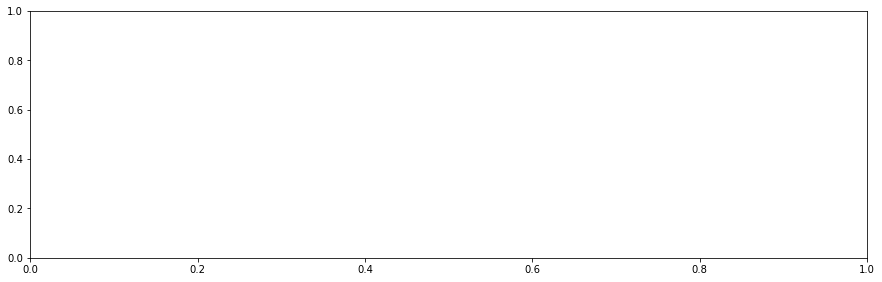

In [29]:
st = 1.24e4
ed = 1.26e4

plt.figure(figsize = [15, 10])
plt.subplot(211)
plt.plot(prediction)
plt.plot(tmpValidation.loc[:,'y'].values)
plt.xlim([st,ed])

plt.subplot(212)
plt.plot(tmpValidation.loc[:,'y'].values-prediction)
plt.xlim([st,ed])

In [ ]:
diff = prediction[1,:]-tripVal.get('y2').values

plt.figure(figsize = [25,25])

plt.subplot(211)
plt.plot(prediction[1,:])
plt.plot(tripVal.get('y2').values)
plt.legend(['prediction','value'])

plt.subplot(212)
plt.plot(diff)

print np.abs(diff).mean()

In [ ]:
diff = prediction[2,:]-tripVal.get('y3').values

plt.figure(figsize = [25,25])

plt.subplot(211)
plt.plot(prediction[2,:])
plt.plot(tripVal.get('y3').values)
plt.legend(['prediction','value'])

plt.subplot(212)
plt.plot(diff)

print np.abs(diff).mean()

In [ ]:
predictionDf = pd.DataFrame(prediction.T,columns=['y1','y2','y3','y4','y5','y6'])
#predictionDf.set_index(tripVal.get('index'),inplace=True)
predictionDf.merge()
predictionDf

In [ ]:
tripVal.head()

In [ ]:
testSet = df3.query('index >= @startTest and index <= @endTest')

In [ ]:
testSet.columns.values
#dropCols = ['index','y','y1','y2','y3','y4','y5','y6']
#tripVal = testSet.get(['index','y','y1','y2','y3','y4','y5','y6','regions'])
#testSet.drop(dropCols,inplace = True, axis = 1)

In [ ]:
df3.columns.values

In [ ]:
df3.columns.values